# Needs vs. Wants Transaction Classifier

This notebook demonstrates a machine learning model that classifies financial transactions as either 'needs' or 'wants'.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import joblib
from IPython.display import display


## Generate Synthetic Transaction Data

Since we're not using Plaid API, we'll create realistic synthetic transaction data for our model.

In [2]:
# Function to create synthetic transaction data
def generate_synthetic_transactions(num_transactions=500):
    # Transaction categories
    need_categories = [
        'Food and Drink > Groceries',
        'Housing > Rent',
        'Housing > Mortgage',
        'Transfer > Deposit',
        'Payment > Credit Card',
        'Travel > Public Transportation',
        'Healthcare > Pharmacy',
        'Service > Utilities',
        'Service > Phone',
        'Service > Internet'
    ]
    
    want_categories = [
        'Food and Drink > Restaurants',
        'Food and Drink > Coffee Shop',
        'Shopping > Clothing',
        'Shopping > Electronics',
        'Travel > Vacation',
        'Travel > Rideshare',
        'Recreation > Gym',
        'Recreation > Entertainment',
        'Personal Care > Spa',
        'Food and Drink > Alcohol & Bars'
    ]
    
    # Merchant names for each category
    merchants = {
        'Food and Drink > Groceries': ['Kroger', 'Safeway', 'Whole Foods', 'Trader Joe\'s', 'Aldi', 'Publix'],
        'Housing > Rent': ['RENT PAYMENT', 'APARTMENT MANAGEMENT', 'PROPERTY MGMT'],
        'Housing > Mortgage': ['MORTGAGE PAYMENT', 'HOME LOAN', 'BANK MORTGAGE'],
        'Transfer > Deposit': ['DIRECT DEPOSIT', 'ACH TRANSFER', 'BANK TRANSFER'],
        'Payment > Credit Card': ['CREDIT CARD PAYMENT', 'CARD SERVICES', 'AMEX PAYMENT', 'CHASE CARD'],
        'Travel > Public Transportation': ['METRO', 'SUBWAY', 'BUS SERVICE', 'TRAIN TICKET', 'TRANSIT AUTHORITY'],
        'Healthcare > Pharmacy': ['CVS', 'Walgreens', 'Rite Aid', 'PHARMACY', 'PRESCRIPTION'],
        'Service > Utilities': ['ELECTRIC COMPANY', 'WATER UTILITY', 'GAS BILL', 'UTILITY PAYMENT'],
        'Service > Phone': ['VERIZON', 'AT&T', 'T-MOBILE', 'SPRINT', 'PHONE BILL'],
        'Service > Internet': ['COMCAST', 'SPECTRUM', 'INTERNET SERVICE', 'WIFI PROVIDER', 'BROADBAND'],
        'Food and Drink > Restaurants': ['McDonald\'s', 'Chipotle', 'Olive Garden', 'Cheesecake Factory', 'Chili\'s', 'Restaurant'],
        'Food and Drink > Coffee Shop': ['Starbucks', 'Dunkin', 'Peet\'s Coffee', 'Coffee Shop', 'Cafe'],
        'Shopping > Clothing': ['H&M', 'Zara', 'Nike', 'Gap', 'Old Navy', 'Macy\'s', 'CLOTHING STORE'],
        'Shopping > Electronics': ['Best Buy', 'Apple Store', 'Amazon', 'Samsung Store', 'Electronics'],
        'Travel > Vacation': ['AIRLINE TICKET', 'HOTEL STAY', 'Airbnb', 'VRBO', 'TRAVEL AGENCY', 'BOOKING.COM'],
        'Travel > Rideshare': ['Uber', 'Lyft', 'TAXI', 'CAB SERVICE'],
        'Recreation > Gym': ['LA Fitness', 'Planet Fitness', 'GYM MEMBERSHIP', 'FITNESS CENTER', '24 Hour Fitness'],
        'Recreation > Entertainment': ['MOVIE THEATER', 'Concert Tickets', 'THEME PARK', 'Netflix', 'Spotify', 'HBO'],
        'Personal Care > Spa': ['MASSAGE', 'SPA SERVICE', 'HAIR SALON', 'NAIL SALON', 'BARBERSHOP'],
        'Food and Drink > Alcohol & Bars': ['BAR', 'LIQUOR STORE', 'Wine Shop', 'Brewery', 'NIGHTCLUB']
    }
    
    # Amount ranges for each category
    amount_ranges = {
        'Food and Drink > Groceries': (30, 200),
        'Housing > Rent': (800, 2500),
        'Housing > Mortgage': (1000, 3000),
        'Transfer > Deposit': (500, 3000),
        'Payment > Credit Card': (200, 1500),
        'Travel > Public Transportation': (2, 15),
        'Healthcare > Pharmacy': (10, 100),
        'Service > Utilities': (50, 200),
        'Service > Phone': (50, 150),
        'Service > Internet': (50, 120),
        'Food and Drink > Restaurants': (15, 100),
        'Food and Drink > Coffee Shop': (3, 15),
        'Shopping > Clothing': (20, 200),
        'Shopping > Electronics': (50, 1000),
        'Travel > Vacation': (200, 2000),
        'Travel > Rideshare': (10, 50),
        'Recreation > Gym': (20, 100),
        'Recreation > Entertainment': (10, 150),
        'Personal Care > Spa': (30, 200),
        'Food and Drink > Alcohol & Bars': (20, 100)
    }
    
    # Create transactions
    transactions = []
    end_date = datetime.datetime.now().date()
    start_date = end_date - datetime.timedelta(days=365)  # One year of data
    
    # Explicitly categorized needs and wants
    need_want_map = {}
    for category in need_categories:
        need_want_map[category] = 'need'
    for category in want_categories:
        need_want_map[category] = 'want'
    
    # Generate transactions
    for _ in range(num_transactions):
        # Determine if this is a need or want (roughly 60% needs, 40% wants)
        is_need = random.random() < 0.6
        
        # Choose category
        if is_need:
            category = random.choice(need_categories)
        else:
            category = random.choice(want_categories)
        
        # Choose merchant name from that category
        name = random.choice(merchants[category])
        
        # Transaction amount based on category
        min_amount, max_amount = amount_ranges[category]
        amount = round(random.uniform(min_amount, max_amount), 2)
        
        # Transaction date - more recent dates are more likely
        days_ago = int(random.triangular(0, 365, 30))  # Most transactions in last month
        date = end_date - datetime.timedelta(days=days_ago)
        
        # Need vs Want classification
        need_want = need_want_map[category]
        
        # Create transaction
        transaction = {
            'date': date,
            'name': name,
            'amount': amount,
            'category': category,
            'need_want': need_want
        }
        
        transactions.append(transaction)
    
    # Create DataFrame and sort by date
    df = pd.DataFrame(transactions)
    df = df.sort_values('date', ascending=False)
    
    return df

# Generate synthetic transaction data
df = generate_synthetic_transactions(500)

# Display the first few rows
print(f"Generated {len(df)} synthetic transactions")
df.head()

Generated 500 synthetic transactions


,date,name,amount,category,need_want
199,2025-03-27,WATER UTILITY,183.05,Service > Utilities,need
158,2025-03-26,FITNESS CENTER,95.75,Recreation > Gym,want
196,2025-03-26,BUS SERVICE,3.16,Travel > Public Transportation,need
421,2025-03-25,H&M,122.61,Shopping > Clothing,want
39,2025-03-24,GAS BILL,134.54,Service > Utilities,need


In [3]:
# Display category distribution
print("Category distribution:")
print(df['category'].value_counts().head(10))

# Display needs vs wants distribution
print("\nNeeds vs. Wants distribution:")
print(df['need_want'].value_counts())
print(df['need_want'].value_counts(normalize=True).map(lambda x: f"{x:.1%}"))

# Calculate spending by category
needs_total = df[df['need_want'] == 'need']['amount'].sum()
wants_total = df[df['need_want'] == 'want']['amount'].sum()
total_spending = needs_total + wants_total

print(f"\nTotal spending on needs: ${needs_total:.2f} ({needs_total/total_spending:.1%})")
print(f"Total spending on wants: ${wants_total:.2f} ({wants_total/total_spending:.1%})")

Category distribution:
category
Service > Utilities               36
Housing > Rent                    36
Payment > Credit Card             34
Housing > Mortgage                33
Transfer > Deposit                32
Service > Phone                   29
Travel > Public Transportation    29
Food and Drink > Groceries        25
Shopping > Clothing               24
Recreation > Gym                  24
Name: count, dtype: int64

Needs vs. Wants distribution:
need_want
need    296
want    204
Name: count, dtype: int64
need_want
need    59.2%
want    40.8%
Name: proportion, dtype: object

Total spending on needs: $228554.14 (85.1%)
Total spending on wants: $39955.35 (14.9%)


# Categorizing Transactions as Needs vs. Wants

In [4]:
# Function to categorize transactions as 'need' or 'want' based on category and name
def categorize_need_want(category, name=None):
    # Comprehensive list of needs categories and keywords
    needs_keywords = [
        # Housing
        'rent', 'mortgage', 'housing', 'hoa', 'apartment', 'property',
        # Utilities
        'utilities', 'electric', 'power', 'gas', 'water', 'sewer', 'trash', 'utility', 'energy',
        # Bills & Services
        'bill', 'phone', 'mobile', 'internet', 'cable', 'wifi', 'subscription',
        # Food Necessities
        'grocery', 'groceries', 'supermarket', 'food',
        # Health
        'pharmacy', 'medical', 'healthcare', 'doctor', 'hospital', 'clinic', 'dental', 'health',
        'medicine', 'prescription', 'drug store',
        # Insurance
        'insurance', 'life insurance', 'health insurance', 'auto insurance', 'car insurance',
        # Transportation
        'gas', 'fuel', 'petrol', 'transit', 'transportation', 'bus', 'train', 'metro', 'subway',
        'commute', 'transport',
        # Education
        'education', 'tuition', 'school', 'university', 'college', 'student', 'book', 'textbook',
        # Debt and Loans
        'loan', 'debt', 'credit card payment', 'student loan', 'finance charge', 'payment', 'transfer'
    ]
    
    # Explicit want categories
    wants_keywords = [
        'restaurant', 'dining', 'bar', 'cafe', 'coffee', 'takeout', 'fast food', 'alcohol',
        'entertainment', 'movie', 'theater', 'cinema', 'concert', 'sport', 'game',
        'shopping', 'clothing', 'shoes', 'accessories', 'electronics', 'gadget',
        'hobby', 'recreation', 'gym', 'fitness',
        'travel', 'hotel', 'vacation', 'trip', 'flight', 'airline',
        'beauty', 'spa', 'salon', 'cosmetics', 'subscription'
    ]
    
    # Convert inputs to lowercase for case-insensitive matching
    category_lower = category.lower() if isinstance(category, str) else ''
    name_lower = name.lower() if isinstance(name, str) else ''
    
    # First check explicit wants (stronger indicator)
    for want in wants_keywords:
        if (want in category_lower) or (name_lower and want in name_lower):
            return 'want'
    
    # Then check for needs
    for need in needs_keywords:
        if (need in category_lower) or (name_lower and need in name_lower):
            return 'need'
    
    # If special categories or common transactions
    if 'transfer' in category_lower and 'internal' in category_lower:
        return 'transfer'  # or 'need' depending on your preference
    
    # If we reach here, default to 'want' (for unrecognized transactions)
    return 'want'

# Test the categorization function on a few sample transactions
sample_transactions = [
    {'name': 'STARBUCKS COFFEE', 'category': 'Food and Drink > Coffee Shop'},
    {'name': 'KROGER', 'category': 'Food and Drink > Groceries'},
    {'name': 'RENT PAYMENT', 'category': 'Housing > Rent'},
    {'name': 'APPLE STORE', 'category': 'Shopping > Electronics'}
]

for tx in sample_transactions:
    category = tx['category']
    name = tx['name']
    classification = categorize_need_want(category, name)
    print(f"{name} - {category}: Classified as {classification.upper()}")

STARBUCKS COFFEE - Food and Drink > Coffee Shop: Classified as WANT
KROGER - Food and Drink > Groceries: Classified as NEED
RENT PAYMENT - Housing > Rent: Classified as NEED
APPLE STORE - Shopping > Electronics: Classified as WANT


## Upload CSV File

Upload a CSV file containing transactions to classify them as 'needs' or 'wants'.

In [5]:
# Function to classify transactions from a CSV file
def classify_transactions_from_csv(file_path):
    try:
        # Read the CSV file
        transactions = pd.read_csv(file_path)

        # Validate required columns
        required_columns = {'date', 'name', 'amount', 'category'}
        if not required_columns.issubset(transactions.columns):
            raise ValueError(f"Missing required columns. Expected columns: {required_columns}")

        # Preprocess transactions
        features = preprocess_transactions(transactions)

        # Predict using the trained model
        predictions = rf_model.predict(features)
        predictions_labels = label_encoder.inverse_transform(predictions)

        # Add predictions to the original DataFrame
        transactions['prediction'] = predictions_labels

        # Display the classified transactions
        display(transactions[['date', 'name', 'amount', 'category', 'prediction']])
    except Exception as e:
        print(f"Error: {e}")

# Example usage
# Replace 'transactions.csv' with the path to your CSV file
# classify_transactions_from_csv('transactions.csv')

## Preprocessing Function

This function preprocesses the transactions to match the model's expected input format.

In [6]:
def preprocess_transactions(transactions):
    """Preprocess transactions to match the model's expected input format."""
    # Handle missing or invalid values
    transactions['date'] = pd.to_datetime(transactions['date'], errors='coerce')
    transactions['name'] = transactions['name'].fillna('Unknown').astype(str)
    transactions['amount'] = pd.to_numeric(transactions['amount'], errors='coerce').fillna(0)
    transactions['category'] = transactions['category'].fillna('Uncategorized').astype(str)

    # Create features for the model
    features = pd.DataFrame()

    # Amount features
    features['amount_abs'] = transactions['amount'].abs()
    features['is_small_purchase'] = (features['amount_abs'] < 20).astype(int)
    features['is_medium_purchase'] = ((features['amount_abs'] >= 20) & (features['amount_abs'] < 100)).astype(int)
    features['is_large_purchase'] = (features['amount_abs'] >= 100).astype(int)

    # Extract name-based features
    for keyword in need_indicators:
        features[f'name_has_{keyword}'] = transactions['name'].str.lower().str.contains(keyword, na=False).astype(int)
    for keyword in want_indicators:
        features[f'name_has_{keyword}'] = transactions['name'].str.lower().str.contains(keyword, na=False).astype(int)

    # Time-based features
    features['is_weekend'] = transactions['date'].dt.dayofweek.isin([5, 6]).astype(int)
    features['day_of_month'] = transactions['date'].dt.day.fillna(15).astype(int)
    features['is_end_of_month'] = (features['day_of_month'] > 25).astype(int)

    # Category-based features
    features['category_is_likely_need'] = transactions['category'].str.lower().apply(
        lambda x: any(need in x for need in ['bank fees', 'groceries', 'housing', 'utilities', 'healthcare', 'transportation'])
    ).astype(int)
    features['category_is_likely_want'] = transactions['category'].str.lower().apply(
        lambda x: any(want in x for want in ['restaurants', 'shopping', 'travel', 'entertainment', 'coffee'])
    ).astype(int)

    # Ensure all expected columns are present
    for col in features_cols:
        if col not in features:
            features[col] = 0

    # Ensure column order matches the model's training data
    features = features[features_cols]
    return features

In [7]:
# Feature engineering for the model
import numpy as np
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Keep track of need and want indicators for later use
need_indicators = ['grocery', 'bill', 'utility', 'gas', 'rent', 'medical', 'insurance']
want_indicators = ['restaurant', 'coffee', 'entertainment', 'shopping', 'travel']

# 1. Process amount (likely our most important feature)
# Amount is often the strongest predictor of need vs want
df['amount_abs'] = df['amount'].abs()  # Use absolute value since expenses might be negative

# Create amount bins - larger purchases more likely to be wants
df['is_small_purchase'] = (df['amount_abs'] < 20).astype(int)  # Small purchases
df['is_medium_purchase'] = ((df['amount_abs'] >= 20) & (df['amount_abs'] < 100)).astype(int)  # Medium
df['is_large_purchase'] = (df['amount_abs'] >= 100).astype(int)  # Large purchases

# 2. Extract features from transaction name
# Create keyword indicators for common needs/wants
for keyword in need_indicators:
    df[f'name_has_{keyword}'] = df['name'].str.lower().str.contains(keyword, na=False).astype(int)

for keyword in want_indicators:
    df[f'name_has_{keyword}'] = df['name'].str.lower().str.contains(keyword, na=False).astype(int)

# 3. Time-based features
df['date'] = pd.to_datetime(df['date'])
df['is_weekend'] = df['date'].dt.dayofweek.isin([5, 6]).astype(int)  # Weekend purchases more likely wants
df['day_of_month'] = df['date'].dt.day
df['is_end_of_month'] = (df['day_of_month'] > 25).astype(int)  # End of month often bills/needs

# 4. Category-based features
# Fix: Ensure all categories are strings
df['category'] = df['category'].apply(lambda x: " > ".join(x) if isinstance(x, list) else x)

# Create category groups based on need vs want patterns
need_categories = ['Bank Fees', 'Food and Drink > Groceries', 'Housing', 'Transfer', 'Payment',
                  'Travel > Public Transportation', 'Healthcare', 'Service', 'Utilities']
want_categories = ['Food and Drink > Restaurants', 'Shopping', 'Travel', 'Recreation', 
                  'Food and Drink > Coffee', 'Entertainment']

df['category_is_likely_need'] = df['category'].apply(lambda x: 
                                             any(need_cat.lower() in x.lower() 
                                                 for need_cat in need_categories if isinstance(x, str))).astype(int)
df['category_is_likely_want'] = df['category'].apply(lambda x: 
                                             any(want_cat.lower() in x.lower() 
                                                 for want_cat in want_categories if isinstance(x, str))).astype(int)

# 5. Periodic spending patterns
# Recurring transactions of same amount are often needs
amount_counts = df.groupby('amount_abs')['amount_abs'].transform('count')
df['is_recurring_amount'] = (amount_counts > 1).astype(int)

# Combine all features
features_cols = ['amount_abs', 'is_small_purchase', 'is_medium_purchase', 'is_large_purchase',
                'is_weekend', 'is_end_of_month', 'category_is_likely_need', 'category_is_likely_want',
                'is_recurring_amount'] + [col for col in df.columns if col.startswith('name_has_')]

features_df = df[features_cols]

# Show the features dataframe
print(f"Number of features: {features_df.shape[1]}")
features_df.head(300)

Number of features: 21


,amount_abs,is_small_purchase,is_medium_purchase,is_large_purchase,is_weekend,is_end_of_month,category_is_likely_need,category_is_likely_want,is_recurring_amount,name_has_grocery,...,name_has_utility,name_has_gas,name_has_rent,name_has_medical,name_has_insurance,name_has_restaurant,name_has_coffee,name_has_entertainment,name_has_shopping,name_has_travel
199,183.05,0,0,1,0,1,1,0,0,0,...,1,0,0,0,0,0,0,0,0,0
158,95.75,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
196,3.16,1,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
421,122.61,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
39,134.54,0,0,1,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,81.81,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
130,1441.70,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
201,761.90,0,0,1,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
94,2390.69,0,0,1,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# Comprehensive description of all features used in the model
import pandas as pd

# Create a DataFrame to display feature descriptions
feature_descriptions = pd.DataFrame({
    'Feature': [
        # Amount-based features
        'amount_abs',
        'is_small_purchase',
        'is_medium_purchase',
        'is_large_purchase',
        
        # Transaction name indicators - Needs
        'name_has_grocery',
        'name_has_bill',
        'name_has_utility',
        'name_has_gas',
        'name_has_rent',
        'name_has_medical',
        'name_has_insurance',
        
        # Transaction name indicators - Wants
        'name_has_restaurant',
        'name_has_coffee',
        'name_has_entertainment',
        'name_has_shopping',
        'name_has_travel',
        
        # Time-based features
        'is_weekend',
        'day_of_month',
        'is_end_of_month',
        
        # Category-based features
        'category_is_likely_need',
        'category_is_likely_want',
        
        # Pattern-based features
        'is_recurring_amount'
    ],
    'Description': [
        # Amount-based features
        'Absolute value of transaction amount (removes negative sign from expenses)',
        'Binary flag (1/0) for transactions under $20 (often small necessities or impulse purchases)',
        'Binary flag (1/0) for transactions between $20-$100 (medium-sized purchases)',
        'Binary flag (1/0) for transactions over $100 (large purchases, often discretionary)',
        
        # Transaction name indicators - Needs
        'Binary flag (1/0) if transaction name contains "grocery" (likely a need)',
        'Binary flag (1/0) if transaction name contains "bill" (likely a need)',
        'Binary flag (1/0) if transaction name contains "utility" (likely a need)',
        'Binary flag (1/0) if transaction name contains "gas" (likely a need)',
        'Binary flag (1/0) if transaction name contains "rent" (likely a need)',
        'Binary flag (1/0) if transaction name contains "medical" (likely a need)',
        'Binary flag (1/0) if transaction name contains "insurance" (likely a need)',
        
        # Transaction name indicators - Wants
        'Binary flag (1/0) if transaction name contains "restaurant" (likely a want)',
        'Binary flag (1/0) if transaction name contains "coffee" (likely a want)',
        'Binary flag (1/0) if transaction name contains "entertainment" (likely a want)',
        'Binary flag (1/0) if transaction name contains "shopping" (likely a want)',
        'Binary flag (1/0) if transaction name contains "travel" (likely a want)',
        
        # Time-based features
        'Binary flag (1/0) if transaction occurred on a weekend (Saturday or Sunday)',
        'The day of month (1-31) when the transaction occurred',
        'Binary flag (1/0) if transaction occurred after the 25th of the month (often bill payments)',
        
        # Category-based features
        'Binary flag (1/0) if transaction category matches common need categories',
        'Binary flag (1/0) if transaction category matches common want categories',
        
        # Pattern-based features
        'Binary flag (1/0) if this exact amount appears multiple times (likely recurring bills)'
    ],
    'Type': [
        # Amount-based features
        'Numeric (Float)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        
        # Transaction name indicators - Needs
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        
        # Transaction name indicators - Wants
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        'Binary (0/1)',
        
        # Time-based features
        'Binary (0/1)',
        'Integer (1-31)',
        'Binary (0/1)',
        
        # Category-based features
        'Binary (0/1)',
        'Binary (0/1)',
        
        # Pattern-based features
        'Binary (0/1)'
    ],
    'Financial Intuition': [
        # Amount-based features
        'Larger amounts are often discretionary spending (wants), while small regular amounts may be needs',
        'Small purchases could be daily necessities or small impulse buys',
        'Medium purchases may include routine shopping or modest discretionary spending',
        'Large purchases often represent major discretionary purchases or significant bills',
        
        # Transaction name indicators - Needs
        'Grocery purchases are typically essential food and household items',
        'Bills represent contractual obligations like utilities, subscriptions, etc.',
        'Utility payments are essential services like electricity, water, etc.',
        'Gas/fuel is typically required for transportation needs',
        'Rent/mortgage payments are essential housing expenses',
        'Medical expenses are typically essential healthcare needs',
        'Insurance payments protect against financial catastrophe',
        
        # Transaction name indicators - Wants
        'Restaurant dining is typically a discretionary expense rather than necessity',
        'Coffee shops represent discretionary spending on beverages/snacks',
        'Entertainment expenses are non-essential leisure activities',
        'Shopping often indicates discretionary retail purchases',
        'Travel expenses are typically non-essential/vacation spending',
        
        # Time-based features
        'Weekend spending tends to be more discretionary/leisure-oriented',
        'Day of month may indicate payment timing patterns',
        'End-of-month often coincides with regular bill and rent payment cycles',
        
        # Category-based features
        'Transactions in categories that typically represent essential expenses',
        'Transactions in categories that typically represent discretionary spending',
        
        # Pattern-based features
        'Transactions that repeat at the same amount are often bills or subscriptions'
    ]
})

# Display the feature descriptions
pd.set_option('display.max_colwidth', None)  # Show full text in columns
pd.set_option('display.max_rows', None)  # Show all rows
display(feature_descriptions)

# Group features by type for easier understanding
print("\nFeatures grouped by category:")
feature_groups = {
    'Amount-based': [col for col in features_df.columns if col.startswith('is_') and 'purchase' in col] + ['amount_abs'],
    'Name-based (Needs)': [col for col in features_df.columns if col.startswith('name_has_') and any(need in col for need in need_indicators)],
    'Name-based (Wants)': [col for col in features_df.columns if col.startswith('name_has_') and any(want in col for want in want_indicators)],
    'Time-based': ['is_weekend', 'day_of_month', 'is_end_of_month'],
    'Category-based': ['category_is_likely_need', 'category_is_likely_want'],
    'Pattern-based': ['is_recurring_amount']
}

for group, cols in feature_groups.items():
    print(f"\n{group} features:")
    for col in cols:
        if col in features_df.columns:
            print(f"  - {col}")

,Feature,Description,Type,Financial Intuition
0,amount_abs,Absolute value of transaction amount (removes negative sign from expenses),Numeric (Float),"Larger amounts are often discretionary spending (wants), while small regular amounts may be needs"
1,is_small_purchase,Binary flag (1/0) for transactions under $20 (often small necessities or impulse purchases),Binary (0/1),Small purchases could be daily necessities or small impulse buys
2,is_medium_purchase,Binary flag (1/0) for transactions between $20-$100 (medium-sized purchases),Binary (0/1),Medium purchases may include routine shopping or modest discretionary spending
3,is_large_purchase,"Binary flag (1/0) for transactions over $100 (large purchases, often discretionary)",Binary (0/1),Large purchases often represent major discretionary purchases or significant bills
4,name_has_grocery,"Binary flag (1/0) if transaction name contains ""grocery"" (likely a need)",Binary (0/1),Grocery purchases are typically essential food and household items
5,name_has_bill,"Binary flag (1/0) if transaction name contains ""bill"" (likely a need)",Binary (0/1),"Bills represent contractual obligations like utilities, subscriptions, etc."
6,name_has_utility,"Binary flag (1/0) if transaction name contains ""utility"" (likely a need)",Binary (0/1),"Utility payments are essential services like electricity, water, etc."
7,name_has_gas,"Binary flag (1/0) if transaction name contains ""gas"" (likely a need)",Binary (0/1),Gas/fuel is typically required for transportation needs
8,name_has_rent,"Binary flag (1/0) if transaction name contains ""rent"" (likely a need)",Binary (0/1),Rent/mortgage payments are essential housing expenses
9,name_has_medical,"Binary flag (1/0) if transaction name contains ""medical"" (likely a need)",Binary (0/1),Medical expenses are typically essential healthcare needs



Features grouped by category:

Amount-based features:
  - is_small_purchase
  - is_medium_purchase
  - is_large_purchase
  - amount_abs

Name-based (Needs) features:
  - name_has_grocery
  - name_has_bill
  - name_has_utility
  - name_has_gas
  - name_has_rent
  - name_has_medical
  - name_has_insurance

Name-based (Wants) features:
  - name_has_restaurant
  - name_has_coffee
  - name_has_entertainment
  - name_has_shopping
  - name_has_travel

Time-based features:
  - is_weekend
  - is_end_of_month

Category-based features:
  - category_is_likely_need
  - category_is_likely_want

Pattern-based features:
  - is_recurring_amount


In [9]:
# Prepare data for modeling
X = features_df

# Make sure we have only numeric data
X = X.select_dtypes(include=['number'])

# Fill any missing values
X = X.fillna(0)

# Target variable
y = df['need_want']

# Print class distribution
print("Class distribution:")
print(y.value_counts())
print(f"Need ratio: {sum(y == 'need')/len(y):.2f}")

# Convert target to binary
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded)

# Use class weights to handle any imbalance
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

print(f"\nClass weights to handle imbalance: {class_weight_dict}")

# Train a Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,  # Prevent overfitting
    min_samples_split=5,  # Minimum samples required to split
    min_samples_leaf=2,  # Minimum samples required at a leaf node
    class_weight=class_weight_dict,  # Handle class imbalance
    random_state=42
)
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

Class distribution:
need_want
need    296
want    204
Name: count, dtype: int64
Need ratio: 0.59

Class weights to handle imbalance: {0: np.float64(0.8454106280193237), 1: np.float64(1.2237762237762237)}

Accuracy: 1.00

Classification Report:
              precision    recall  f1-score   support

        need       1.00      1.00      1.00        89
        want       1.00      1.00      1.00        61

    accuracy                           1.00       150
   macro avg       1.00      1.00      1.00       150
weighted avg       1.00      1.00      1.00       150



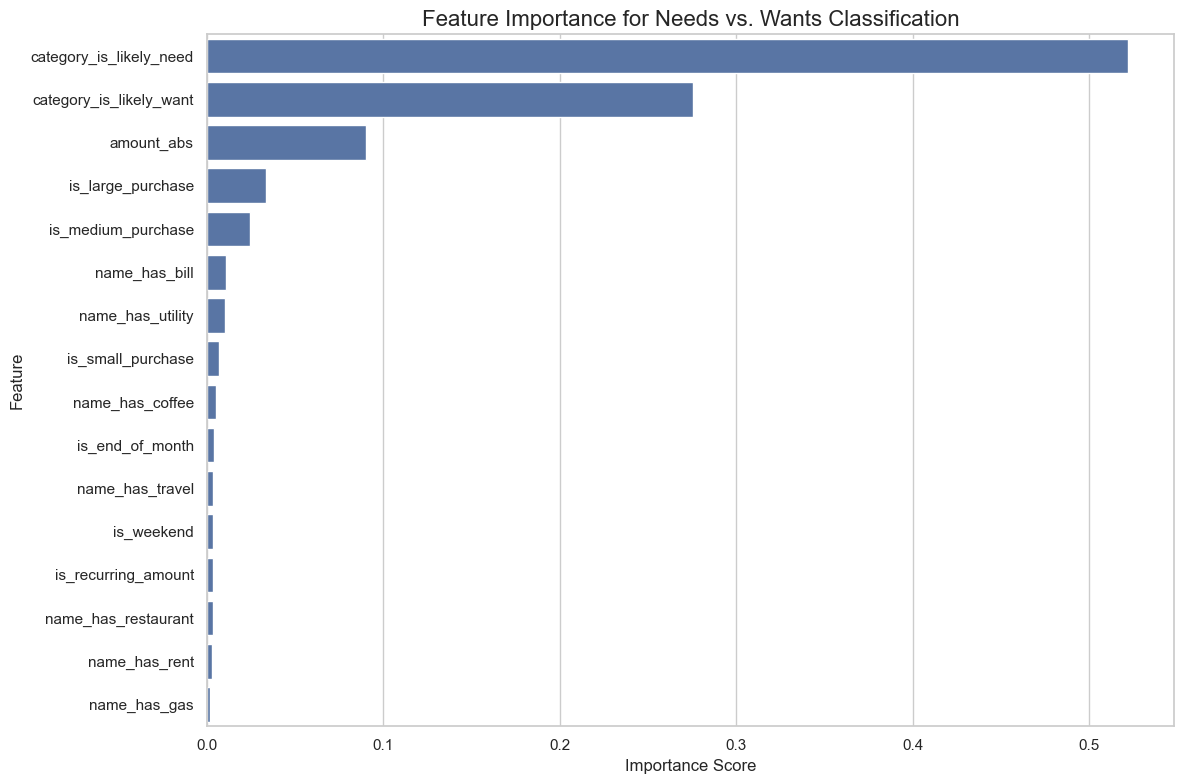

Top features for classification:
7. category_is_likely_need: 0.5221
8. category_is_likely_want: 0.2754
1. amount_abs: 0.0901
4. is_large_purchase: 0.0336
3. is_medium_purchase: 0.0245
11. name_has_bill: 0.0106
12. name_has_utility: 0.0103
2. is_small_purchase: 0.0067
18. name_has_coffee: 0.0050
6. is_end_of_month: 0.0038


<Figure size 1000x800 with 0 Axes>

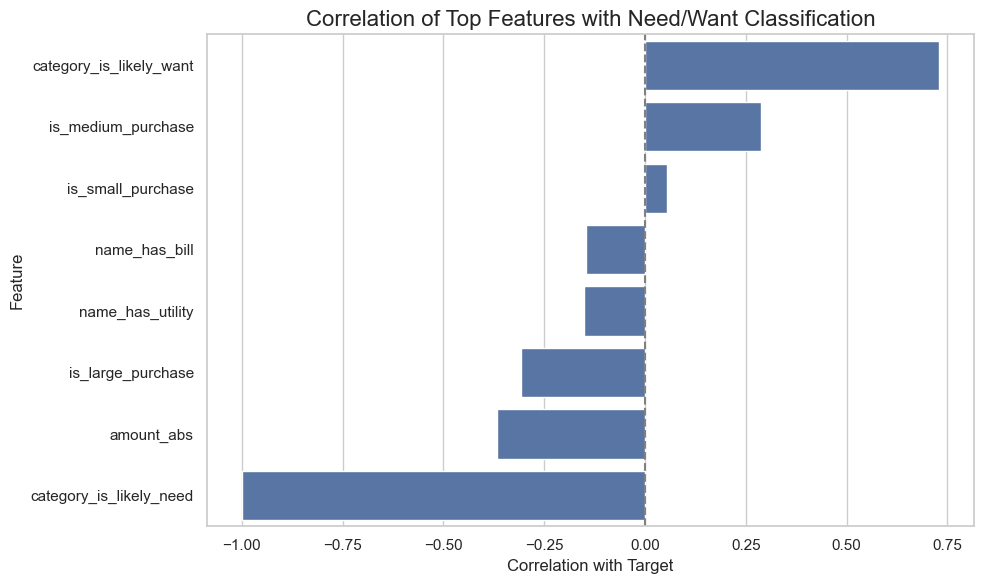


Correlation of top features with target (need/want):
category_is_likely_want: 0.730 (more likely a want)
is_medium_purchase: 0.287 (more likely a want)
is_small_purchase: 0.055 (more likely a want)
name_has_bill: -0.146 (more likely a need)
name_has_utility: -0.151 (more likely a need)
is_large_purchase: -0.307 (more likely a need)
amount_abs: -0.368 (more likely a need)
category_is_likely_need: -1.000 (more likely a need)


In [10]:
# Analyze feature importance with visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for easy analysis
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Only show features with non-zero importance
important_features = feature_importance_df[feature_importance_df['Importance'] > 0.001]

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

# Create a more attractive barplot
ax = sns.barplot(x='Importance', y='Feature', data=important_features)
plt.title('Feature Importance for Needs vs. Wants Classification', fontsize=16)
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()

# Print top features and their importance
print("Top features for classification:")
for i, row in important_features.head(10).iterrows():
    print(f"{i+1}. {row['Feature']}: {row['Importance']:.4f}")

# Show correlation matrix of top features with target
top_features = important_features['Feature'].tolist()[:8]  # Get top 8 features
correlation_data = X[top_features].copy()
correlation_data['target'] = y_encoded

plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr()
target_correlations = correlation_matrix['target'].drop('target').sort_values(ascending=False)

# Plot correlation of features with target
plt.figure(figsize=(10, 6))
sns.barplot(x=target_correlations.values, y=target_correlations.index)
plt.title('Correlation of Top Features with Need/Want Classification', fontsize=16)
plt.xlabel('Correlation with Target', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.axvline(x=0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

print("\nCorrelation of top features with target (need/want):")
for feature, corr in target_correlations.items():
    direction = "more likely a need" if corr < 0 else "more likely a want"
    print(f"{feature}: {corr:.3f} ({direction})")

In [11]:
# Apply the model to predict on all transactions
# We need to use the same feature processing as we did for training

# Process features_df the same way we processed X for training
prediction_data = features_df.copy()

# Drop non-numeric columns (to match the process used during training)
prediction_data = prediction_data.select_dtypes(exclude=['object'])

# Ensure columns match those used for training
missing_cols = set(X.columns) - set(prediction_data.columns)
for col in missing_cols:
    prediction_data[col] = 0  # Add missing columns with default values

# Ensure column order matches training data
prediction_data = prediction_data[X.columns]

# Now we can predict
all_predictions = rf_model.predict(prediction_data)
all_predictions_labels = label_encoder.inverse_transform(all_predictions)

# Add predictions to the original dataframe
df['predicted_need_want'] = all_predictions_labels

# Calculate needs vs. wants ratio based on predictions
need_amount = df[df['predicted_need_want'] == 'need']['amount'].sum()
want_amount = df[df['predicted_need_want'] == 'want']['amount'].sum()
total_amount = need_amount + want_amount

print(f"Total spending on needs: ${need_amount:.2f} ({need_amount/total_amount*100:.1f}%)")
print(f"Total spending on wants: ${want_amount:.2f} ({want_amount/total_amount*100:.1f}%)")

# Compare actual vs predicted distributions
print("\nActual needs vs. wants distribution:")
print(df['need_want'].value_counts(normalize=True).map(lambda x: f"{x:.1%}"))

print("\nPredicted needs vs. wants distribution:")
print(df['predicted_need_want'].value_counts(normalize=True).map(lambda x: f"{x:.1%}"))

# Display sample transactions with their classifications
display_cols = ['date', 'name', 'amount', 'category', 'need_want', 'predicted_need_want']
df[display_cols].sample(10)

Total spending on needs: $228554.14 (85.1%)
Total spending on wants: $39955.35 (14.9%)

Actual needs vs. wants distribution:
need_want
need    59.2%
want    40.8%
Name: proportion, dtype: object

Predicted needs vs. wants distribution:
predicted_need_want
need    59.2%
want    40.8%
Name: proportion, dtype: object


,date,name,amount,category,need_want,predicted_need_want
370,2025-02-19,METRO,10.01,Travel > Public Transportation,need,need
290,2024-11-05,TRAIN TICKET,13.14,Travel > Public Transportation,need,need
429,2024-10-24,Whole Foods,179.18,Food and Drink > Groceries,need,need
313,2024-08-11,Wine Shop,89.95,Food and Drink > Alcohol & Bars,want,want
128,2025-01-28,UTILITY PAYMENT,69.97,Service > Utilities,need,need
314,2024-04-30,CAB SERVICE,14.07,Travel > Rideshare,want,want
44,2024-12-30,NAIL SALON,167.21,Personal Care > Spa,want,want
61,2024-06-09,GYM MEMBERSHIP,98.51,Recreation > Gym,want,want
427,2024-10-27,TRANSIT AUTHORITY,5.47,Travel > Public Transportation,need,need
113,2024-10-19,DIRECT DEPOSIT,600.90,Transfer > Deposit,need,need


## Load Data from CSV and Predict

This cell allows you to load transaction data from a CSV file and classify each transaction as a 'need' or 'want'.

In [12]:
import pandas as pd

# Load CSV file
file_path = 'transactions.csv'  # Replace with your CSV file path
try:
    transactions = pd.read_csv(file_path)
    print(f"Loaded {len(transactions)} transactions from {file_path}")

    # Validate required columns
    required_columns = {'date', 'name', 'amount', 'category'}
    if not required_columns.issubset(transactions.columns):
        raise ValueError(f"Missing required columns. Expected columns: {required_columns}")

    # Preprocess transactions
    features = preprocess_transactions(transactions)

    # Predict using the trained model
    predictions = rf_model.predict(features)
    predictions_labels = label_encoder.inverse_transform(predictions)

    # Add predictions to the original DataFrame
    transactions['prediction'] = predictions_labels

    # Display the classified transactions
    display(transactions[['date', 'name', 'amount', 'category', 'prediction']])

except Exception as e:
    print(f"Error: {e}")

Error: [Errno 2] No such file or directory: 'transactions.csv'


In [13]:
# Function to predict need vs want for a single transaction
def predict_single_transaction(transaction_data):
    # Create a dataframe with this single transaction
    test_transaction = pd.DataFrame([transaction_data])
    
    # Create the same features we used for training
    features = {}
    
    # Amount features
    amount_abs = abs(float(transaction_data.get('amount', 0)))
    features['amount_abs'] = amount_abs
    features['is_small_purchase'] = 1 if amount_abs < 20 else 0
    features['is_medium_purchase'] = 1 if 20 <= amount_abs < 100 else 0
    features['is_large_purchase'] = 1 if amount_abs >= 100 else 0
    
    # Extract name-based features
    name = transaction_data.get('name', '').lower()
    
    # Need indicators
    for keyword in need_indicators:
        features[f'name_has_{keyword}'] = 1 if keyword in name else 0
        
    # Want indicators
    for keyword in want_indicators:
        features[f'name_has_{keyword}'] = 1 if keyword in name else 0
    
    # Time-based features
    if 'date' in transaction_data:
        date = pd.to_datetime(transaction_data['date'])
        features['is_weekend'] = 1 if date.dayofweek >= 5 else 0
        features['day_of_month'] = date.day
        features['is_end_of_month'] = 1 if date.day > 25 else 0
    else:
        features['is_weekend'] = 0
        features['day_of_month'] = 15  # Default to middle of month
        features['is_end_of_month'] = 0
    
    # Category-based features
    category = transaction_data.get('category', '').lower()
    
    # Need categories
    need_categories = ['bank fees', 'food and drink > groceries', 'housing', 'transfer', 'payment',
                       'travel > public transportation', 'healthcare', 'service', 'utilities']
    features['category_is_likely_need'] = 1 if any(need_cat.lower() in category for need_cat in need_categories) else 0
    
    # Want categories
    want_categories = ['food and drink > restaurants', 'shopping', 'travel', 'recreation',
                       'food and drink > coffee', 'entertainment']
    features['category_is_likely_want'] = 1 if any(want_cat.lower() in category for want_cat in want_categories) else 0
    
    # Pattern-based features - for single transaction we don't know if it's recurring
    features['is_recurring_amount'] = 0  # Default to not recurring
    
    # Convert to DataFrame
    features_df = pd.DataFrame([features])
    
    # Ensure all expected features are present
    for feature in X.columns:
        if feature not in features_df.columns:
            features_df[feature] = 0
    
    # Ensure column order matches training data
    features_df = features_df[X.columns]
    
    # Make prediction
    prediction = rf_model.predict(features_df)[0]
    prediction_label = label_encoder.inverse_transform([prediction])[0]
    
    # Get prediction probability
    proba = rf_model.predict_proba(features_df)[0]
    confidence = proba[prediction] * 100  # Convert to percentage
    
    return {
        'prediction': prediction_label,
        'confidence': confidence,
        'features': features
    }

# Test the model with a transaction example
test_transaction = {
    'date': '2023-06-15',
    'name': 'pharmacy',
    'amount': 49,
    'category': 'healthcare'
}

# Run the prediction
result = predict_single_transaction(test_transaction)

# Display results
print(f"\n===== TRANSACTION DETAILS =====")
print(f"Date: {test_transaction['date']}")
print(f"Name: {test_transaction['name']}")
print(f"Amount: ${test_transaction['amount']:.2f}")
print(f"Category: {test_transaction['category']}")

print(f"\n===== PREDICTION RESULTS =====")
print(f"Classification: This is a {result['prediction'].upper()}")
print(f"Confidence: {result['confidence']:.1f}%")

print(f"\n===== KEY FEATURES =====")
features = result['features']

# Display amount-based features
print(f"Amount: ${features['amount_abs']:.2f}")
if features['is_small_purchase']:
    print("- This is a small purchase (under $20)")
elif features['is_medium_purchase']:
    print("- This is a medium-sized purchase ($20-$100)")
else:
    print("- This is a large purchase (over $100)")

# Show matched keywords
matched_needs = [kw for kw in need_indicators if features.get(f'name_has_{kw}', 0) == 1]
if matched_needs:
    print(f"- Contains need-related keywords: {', '.join(matched_needs)}")

matched_wants = [kw for kw in want_indicators if features.get(f'name_has_{kw}', 0) == 1]
if matched_wants:
    print(f"- Contains want-related keywords: {', '.join(matched_wants)}")

# Category info
if features['category_is_likely_need']:
    print("- Category typically associated with needs")
if features['category_is_likely_want']:
    print("- Category typically associated with wants")


===== TRANSACTION DETAILS =====
Date: 2023-06-15
Name: pharmacy
Amount: $49.00
Category: healthcare

===== PREDICTION RESULTS =====
Classification: This is a NEED
Confidence: 77.9%

===== KEY FEATURES =====
Amount: $49.00
- This is a medium-sized purchase ($20-$100)
- Category typically associated with needs


In [14]:
import joblib

# Save the trained model
joblib.dump(rf_model, 'rf_model.pkl')

# Save the label encoder
joblib.dump(label_encoder, 'label_encoder.pkl')

# Save the list of features used during training
joblib.dump(X.columns.tolist(), 'model_columns.pkl')

# Save need and want indicators (so your API can reuse them)
joblib.dump(need_indicators, 'need_indicators.pkl')
joblib.dump(want_indicators, 'want_indicators.pkl')

print("Model and supporting files saved successfully!")

Model and supporting files saved successfully!
